In [1]:
# import logging
import os
import re
from pathlib import Path
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import torch
import wandb
import yaml
from einops import rearrange

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from mushroom.mushroom import Mushroom
import mushroom.data.xenium as xenium
import mushroom.data.visium as visium
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils

/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()


In [5]:
wandb.login()

wandb: Currently logged in as: estorrs (tme-st). Use `wandb login --relogin` to force relogin


True

In [6]:
run_dir = '/data/estorrs/mushroom/data/projects/xenium_grant'
mushroom_dir = os.path.join(run_dir, 'mushroom')
config_fps = sorted(utils.listfiles(mushroom_dir, regex=r'/config.yaml'))
config_fps

['/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/HT206B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/S18-25943/config.yaml',
 '/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/S18-9906/config.yaml']

In [7]:
# only relavent for dinglab data since our channel names are all over the place
# will remove for official example
official_to_options = {
    'Pan-Cytokeratin': ['Pan-Cytokeratin', 'Pan-CK', 'Pan-CK (D)', 'PanCK (D)'],
    'E-cadherin': ['E-cadherin'],
    'CD45': ['CD45 (D)', 'CD45', 'CD45-(D)', 'CD45(D)'],
    'CD45RO': ['CD45RO'],
    'CD45RA': ['CD45RA'],
    'CD8': ['CD8', 'CD8a'],
    'DAPI': ['DAPI'],
    'CD4': ['CD4', 'CD4 (D)'],
    'CD3e': ['CD3e', 'CD3'],
    'Vimentin': ['Vimentin-(D)', 'Vimentin', 'Vimentin (D)'],
    'SMA': ['SMA-(D)', 'SMA', 'SMA (D)', 'a-SMA (D)'],
    'CD31': ['CD31', 'CD31-(D)', 'CD31 (D)'],
    'CD20': ['CD20-(D)', 'CD20', 'CD20 (D)', 'CD20-Akoya'],
    'CD68': ['CD68', 'CD68 (D)', 'CD68-(D)'],
    'CD163': ['CD163'],
    'FOXP3': ['FoxP3', 'FOXP3', 'Foxp3'],
    'cKit': ['cKIT (D)', 'cKit (D)', 'cKit', 'cKIT', 'cKIT-(D)'],
    'MGP': ['MGP', 'MGP (D)', 'MGP-(D)'],
    'CD36': ['CD36-(D)', 'CD36'],
    'PR': ['PR', 'PR-(D)', 'PR (D)'],
    'ER': ['ER', 'ER-(D)', 'ER (D)'],
    'P21': ['P21', 'P21-(D)', 'P21-(D)', 'P21 (D)'],
    'P16': ['P16-(D)'],
    'CK5': ['Keratin 5', 'KRT5'],
    'TFF1': ['TFF1', 'TFF1-(D)', 'TFF1 (D)'],
    'beta-integrin': ['beta-integrin', 'beta3-integrin'],
    'CK14': ['CK14', 'Keratin 14', 'CK14 (D)'],
    'CK17': ['CK17', 'CK17 (D)', 'CK17-(D)', 'Keratin 17'],
    'CK19': ['CK19', 'CK19 (D)', 'CK19-(D)'],
    'CD11b': ['CD11b', 'CD11b (D)', 'CD11b-(D)'],
    'GATA3': ['GATA3', 'GATA3-(D)', 'GATA3 (D)'],
    'PLAT/tPA': ['PLAT/tPA', 'PLAT/tPA (D)'],
    'COX6c': ['COX6c (D)'],
    'Her2': ['Her2', 'Her2 (D)'],
    'Bap1': ['Bap1 (D)'],
    'GLUT1': ['Glut1', 'GLUT1', 'GLUT1-(D)', 'GLUT1 (D)'],
    'CD11c': ['CD11c'],
    'HLA-DR': ['HLA-DR'],
    'Ki67': ['Ki67', 'KI67'],
    'Podoplanin': ['Podoplanin', 'PDPN', 'Podoplanin (D)'],
    'CTLA4': ['CTLA4', 'CTLA4 (D)', 'CTLA4-(D)'],
    'SLC39A6': ['SLC39A6'],
    'BCA1': ['BCA1'],
    'BCAL': ['BCAL'],
    'TUBB3': ['TUBB3', 'TUBB3 (D)'],
    'PTPRZ1': ['PTPRZ1', 'PTPRZ1 (D)'],
    'HIF1A': ['HIF1a', 'HIF1a (D)', 'HIF1A'],
    'PAI1': ['PAI1', 'PAI1-(D)'],
    'GFAP': ['GFAP', 'GFAP (D)'],
    'VEGFA': ['VEGFA', 'VEGFA (D)'],
    'IBA1': ['IBA1', 'IBA1 (D)'],
    'OLIG2': ['OLIG2', 'OLIG2 (D)'],
    'FN1': ['FN1', 'FN1 (D)'],
    'a-Amylase': ['a-Amylase'],
    'Hep-Par-1': ['Hep-Par-1 (D)'],
    'Granzyme-B': ['Granzyme B'],
    'TCF-1': ['TCF-1'],
    'CD39': ['CD39'],
    'PD1': ['PD-1'],
    'PDL1': ['PD-L1'],
    'Histone-H3-Pho': ['Histone H3 Pho'],
    'Maspin': ['Maspin'],
    'MMP9': ['MMP9'],
    'CD44': ['CD44'],
    'CD107A': ['CD107a'],
    'FGFR3': ['FGFR3'],
    'CD138': ['CD138'],
    'MLPH': ['MLPH'],
    'P63': ['P63'],
    'GP2': ['GP2'],
    'COX2': ['COX2'],
    'Lyve-1': ['Lyve-1'],
}
channel_mapping = {v:k for k, vs in official_to_options.items() for v in vs}
# channel_mapping = None

In [8]:
mushroom_config = {
    'dtype': 'multiplex',
#     'sections': config,
    'sae_kwargs': {
        'size': 256,
        'patch_size': 32,
        'encoder_dim': 256,
        'kl_scaler': 0.,
        'recon_scaler': 1.,
        'neigh_scaler': .0,
        'codebook_size': 30,
        'decoder_dims': (256, 50, 50,)
    },
    'trainer_kwargs': {
        'scale': .5,
        'contrast_pct': None,
        'pct_expression': .02,
        'batch_size': 64,
        'num_workers': 10,
        'devices': 1,
        'accelerator': 'gpu',
        'enable_checkpointing': True,
        'max_epochs': 5,
        'steps_per_epoch': 200,
        'channels': None,
        'channel_mapping': channel_mapping,
        'lr': 1e-4,
        'save_every': 1,
        'save_dir': './',
        'log_dir': './',
        'log_every_n_steps': 10,
#         'logger_project': 'model_testing_S18-9906',
        'logger_channel': 'CD45',
        'logger_type': 'wandb'
    },
}

In [9]:
config_fp = '/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/S18-9906/config.yaml'

case = config_fp.split('/')[-2]
out_dir = os.path.join(f'/data/estorrs/mushroom/data/projects/testing/mushroom/{case}_v1/outputs')
save_dir = os.path.join(out_dir, 'chkpts')
log_dir = os.path.join(out_dir, 'logs')

Path(save_dir).mkdir(parents=True, exist_ok=True)

config = yaml.safe_load(open(config_fp))

In [10]:
mushroom_config['sections'] = config
mushroom_config['trainer_kwargs']['logger_project'] = f'model_testing_{case}'
mushroom_config['trainer_kwargs']['save_dir'] = save_dir
mushroom_config['trainer_kwargs']['log_dir'] = log_dir

In [11]:
yaml.safe_dump(
    mushroom_config,
    open(os.path.join(mushroom_config['trainer_kwargs']['save_dir'], 'mushroom_config.yaml'), 'w')
)

In [12]:
mushroom = Mushroom.from_config(mushroom_config)

INFO:root:generating inputs for multiplex tissue sections
INFO:root:using 24 channels
INFO:root:4 sections detected: ['s1', 's3', 's5', 's7']
INFO:root:processing sections
INFO:root:generating image data for section s1
INFO:root:generating image data for section s3
INFO:root:generating image data for section s5
INFO:root:generating image data for section s7
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [13]:
mushroom.train()

/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /data/estorrs/mushroom/data/projects/testing/mushroom/S18-9906_v1/outputs/chkpts exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 16.3 M
------------------------------
16.3 M    Trainable params
0         Non-trainable params
16.3 M    Total params
65.220    Total estimated model params size (MB)


Training: |                                                                                         | 0/? [00:…

`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
# ~.75 iter per second

In [14]:
os.path.join(mushroom_config['trainer_kwargs']['save_dir'], 'mushroom_config.yaml')

'/data/estorrs/mushroom/data/projects/testing/mushroom/S18-9906_v1/outputs/chkpts/mushroom_config.yaml'

In [15]:
new = Mushroom.from_config(
    '/data/estorrs/mushroom/data/projects/testing/mushroom/S18-9906_v1/outputs/chkpts/mushroom_config.yaml',
    chkpt_filepath='/data/estorrs/mushroom/data/projects/testing/mushroom/S18-9906_v1/outputs/chkpts/epoch=9-step=1000.ckpt',
    accelerator='cpu'
)


INFO:root:generating inputs for multiplex tissue sections
INFO:root:using 24 channels
INFO:root:4 sections detected: ['s1', 's3', 's5', 's7']
INFO:root:processing sections
INFO:root:generating image data for section s1
INFO:root:generating image data for section s3
INFO:root:generating image data for section s5
INFO:root:generating image data for section s7
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/lightning/pytorch/loggers/wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/estorrs/miniconda3/envs/m

In [16]:
new.embed_sections()

Predicting: |                                                                                                 …

array([[<Axes: title={'center': 's1'}, ylabel='predicted'>,
        <Axes: title={'center': 's3'}>, <Axes: title={'center': 's5'}>,
        <Axes: title={'center': 's7'}>],
       [<Axes: ylabel='true'>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

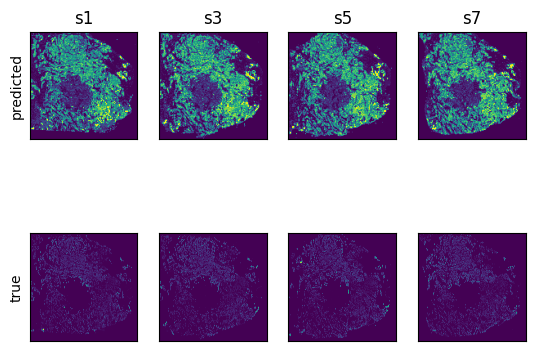

In [17]:
new.display_predicted_pixels('Pan-Cytokeratin')

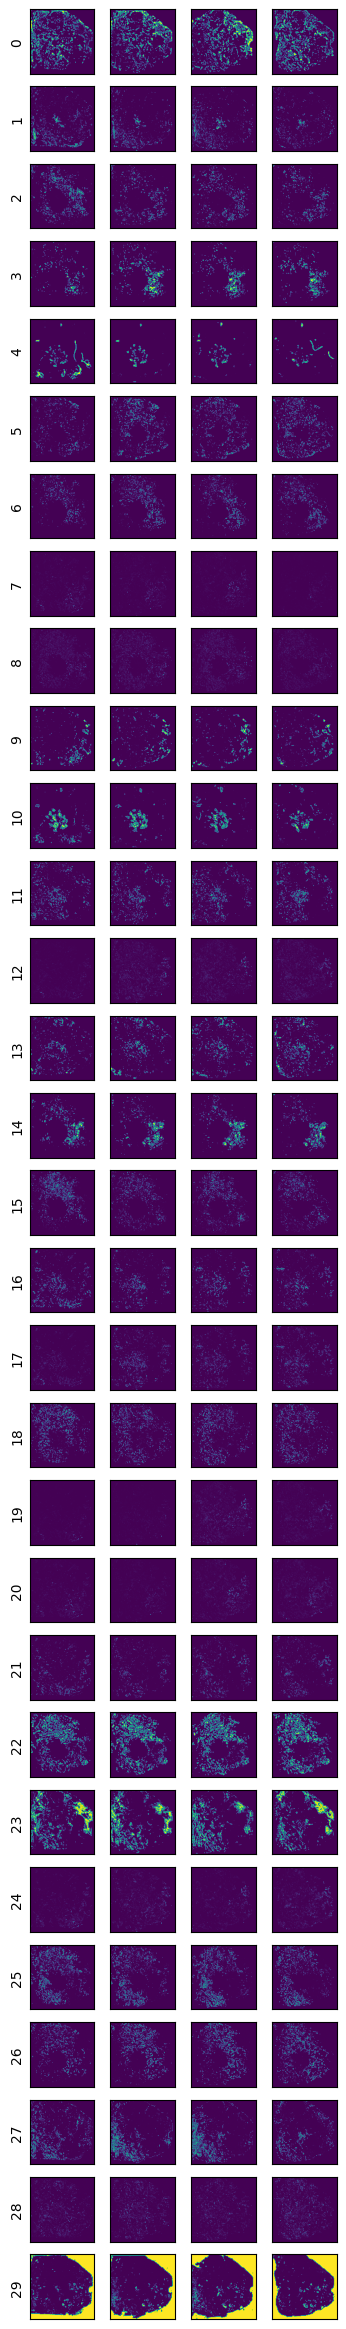

In [18]:
new.display_cluster_probs()

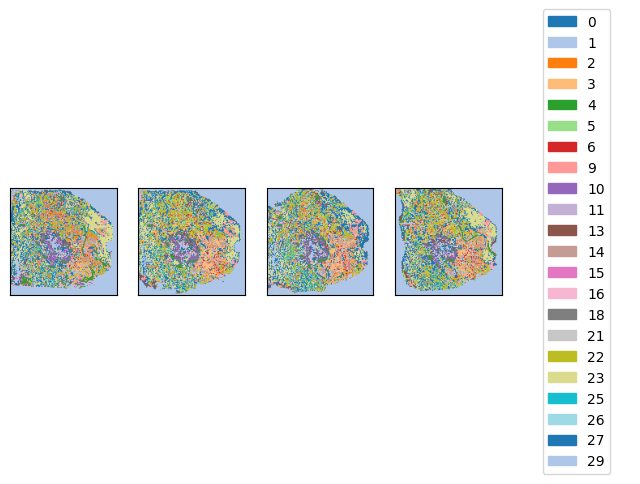

In [19]:
new.display_clusters()

In [20]:
df = new.get_cluster_intensities()
df

,AMACR,AR,CD20,CD31,CD3e,CD4,CD45,CD68,CD8,CK14,...,FOXP3,HLA-DR,Ki67,LYVE1,Pan-Cytokeratin,Podoplanin,SMA,STEAP4,Vimentin,p63
0,-0.059871,-0.049944,-0.026801,0.010065,-0.020238,-0.011825,0.169683,-0.146661,-0.026230,-0.036398,...,-0.035878,-0.049348,-0.041479,0.063132,-0.228490,-0.041800,0.921122,-0.222097,0.043931,-0.051316
1,-0.039400,-0.078652,-0.045922,-0.012635,-0.021351,-0.015724,-0.063363,-0.126358,-0.031552,-0.024426,...,-0.102359,-0.025530,-0.050808,-0.078366,-0.099516,-0.024538,-0.147461,-0.006289,-0.010842,-0.038350
2,-0.044898,0.054697,-0.034654,-0.025842,-0.046586,-0.050836,-0.091236,0.202020,-0.032399,-0.025374,...,-0.021760,-0.025303,-0.024740,0.040571,0.296000,-0.045907,-0.279504,-0.034106,-0.096353,-0.028331
3,0.003269,0.311433,0.104840,0.040177,-0.025428,-0.014097,0.034618,0.898417,-0.006037,0.238599,...,-0.007365,0.060955,0.024492,0.336885,0.737925,-0.082830,-0.256681,-0.096408,-0.094140,-0.007644
4,0.901707,0.910076,0.897531,0.916713,0.928084,0.928174,0.920296,0.897139,0.890341,0.911718,...,0.890841,0.913794,0.885265,0.911743,-0.012359,0.901676,-0.213376,0.908937,0.928165,0.881800
5,-0.017625,0.377932,0.089912,0.195860,0.066485,0.067147,0.187243,0.288758,-0.003409,0.102277,...,0.035271,0.052049,0.031012,0.353817,0.440151,0.034763,0.191652,0.325774,0.261926,0.006962
6,-0.054891,0.221793,0.023914,0.069264,-0.009702,-0.018010,0.078993,0.305629,-0.039944,0.034970,...,0.011592,-0.010436,-0.013108,0.267650,0.408269,-0.048634,0.171105,-0.000007,0.059523,-0.031805
9,0.112646,0.608696,0.246411,0.285198,0.214285,0.219522,0.210167,0.597609,0.120337,0.503729,...,0.181432,0.239553,0.253545,0.316498,0.870653,0.178185,-0.240510,0.817831,0.313676,0.105649
10,0.398496,0.430106,0.368488,0.491972,0.551649,0.552633,0.515722,0.333818,0.330006,0.431997,...,0.323864,0.462888,0.289779,0.457894,-0.135597,0.395818,0.032794,0.394629,0.565202,0.283411
11,-0.004754,0.063119,0.015795,0.122234,0.055757,0.065733,0.118713,-0.131050,-0.014789,0.049826,...,-0.060936,0.020092,-0.029262,0.066566,-0.179565,0.009854,0.349744,0.005376,0.197132,-0.010943


In [21]:
volume = new.generate_interpolated_volume(z_scaler=.1)
volume.shape

(11, 132, 132)

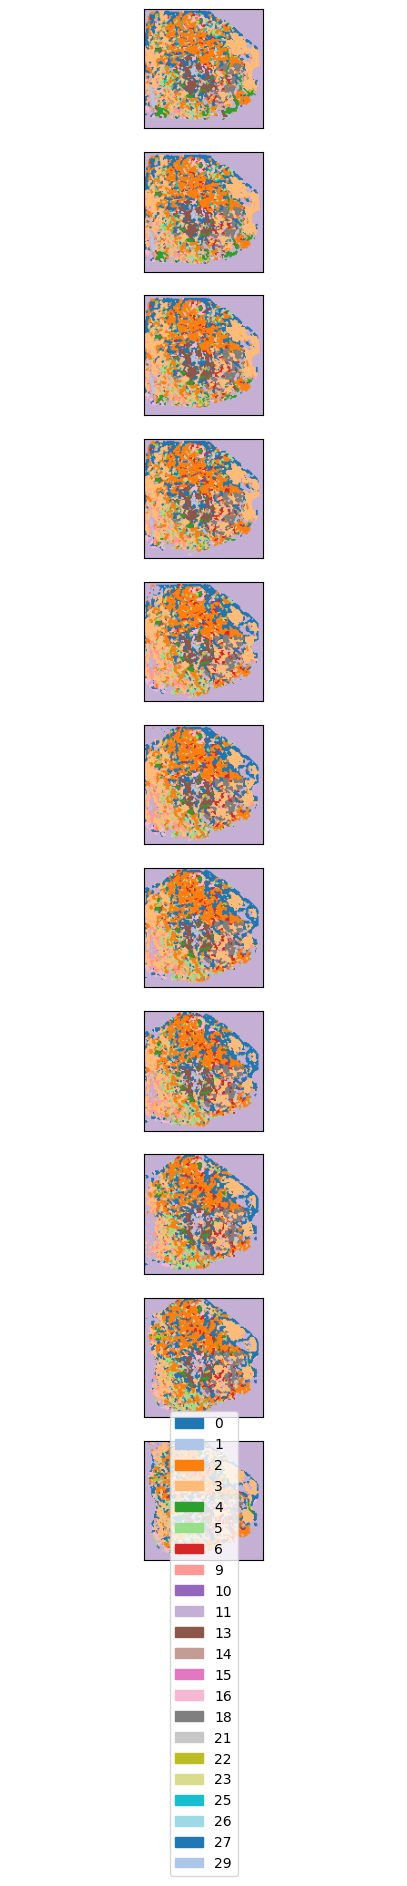

In [23]:
vis_utils.display_clusters(volume, horizontal=False, preserve_indices=True)

In [15]:
mushroom.model.sae.encoder.to_patch_embedding

Sequential(
  (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
  (1): LayerNorm((24576,), eps=1e-05, elementwise_affine=True)
  (2): Linear(in_features=24576, out_features=256, bias=True)
  (3): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
)

In [23]:
next(iter(mushroom.model.sae.encoder.to_patch_embedding[1].parameters())).shape[0]

24576

In [24]:
x = tuple([1,2,3])

[autoreload of mushroom.model.sae failed: Traceback (most recent call last):
  File "/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/data/estorrs/mushroom/mushroom/model/sae.py", line 13, in <module>
    class SAEargs:
  File "/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/dataclasses.py", line 1021, in dataclass
    return wrap(cls)
  File "/data/es

In [25]:
x

(1, 2, 3)

In [28]:
x.index(2)

1

In [29]:
mushroom.model.sae.encoder.pos_embedding.shape[-2:]

[autoreload of mushroom.model.sae failed: Traceback (most recent call last):
  File "/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/data/estorrs/mushroom/mushroom/model/sae.py", line 13, in <module>
    class SAEargs:
  File "/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/dataclasses.py", line 1021, in dataclass
    return wrap(cls)
  File "/data/es

torch.Size([65, 256])

In [30]:
mushroom.model.sae.encoder.pos_embedding

[autoreload of mushroom.model.sae failed: Traceback (most recent call last):
  File "/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/data/estorrs/mushroom/mushroom/model/sae.py", line 13, in <module>
    class SAEargs:
  File "/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/dataclasses.py", line 1021, in dataclass
    return wrap(cls)
  File "/data/es

Parameter containing:
tensor([[[-0.8363, -0.6300,  0.6521,  ..., -0.3803,  0.0390, -0.3210],
         [ 1.8996,  2.5042,  1.6279,  ...,  0.8233,  0.5704, -0.8201],
         [-0.9232, -1.2193, -0.8342,  ...,  0.3424, -1.6530, -1.0438],
         ...,
         [-0.6818, -2.1101,  1.2432,  ...,  0.3103, -0.0099,  0.6781],
         [ 0.8664,  0.0890, -0.0797,  ...,  0.1130,  0.7016, -0.7985],
         [-0.5886, -0.5898,  0.9991,  ...,  2.5651, -0.1768,  0.0755]]],
       requires_grad=True)

In [46]:
x = torch.rand(200, 200, 10000)
x.shape

torch.Size([200, 200, 10000])

In [48]:
x.size()

torch.Size([200, 200, 10000])

In [53]:
x.element_size() * x.nelement()

1600000000

In [20]:
from vit_pytorch import ViT

In [7]:
import torch.nn.functional as F
import torch
from einops import rearrange, repeat

In [22]:
encoder = ViT(image_size=256,
    patch_size=32,
    num_classes=100,
    dim=128,
    depth=6,
    heads=2,
    mlp_dim=1000,)

In [ ]:
self.patch_dim = next(iter(encoder.to_patch_embedding[1].parameters())).shape[0]

In [23]:
encoder.to_patch_embedding

Sequential(
  (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
  (1): LayerNorm((3072,), eps=1e-05, elementwise_affine=True)
  (2): Linear(in_features=3072, out_features=128, bias=True)
  (3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
)

In [25]:
encoder.to_patch_embedding[0].axes_lengths['p1']

32

In [42]:
anchor_clusters = torch.randint(10, (4, 5))
pos_clusters = torch.randint(10, (4, 5))
anchor_clusters, pos_clusters

(tensor([[3, 8, 3, 9, 1],
         [4, 3, 6, 8, 6],
         [6, 8, 2, 0, 5],
         [0, 8, 3, 7, 5]]),
 tensor([[8, 6, 5, 3, 6],
         [0, 5, 2, 5, 5],
         [0, 0, 6, 5, 9],
         [8, 0, 5, 4, 8]]))

In [43]:
anchor_pairs = torch.tensor([2,3,1,0,4])
pos_pairs = torch.tensor([1,2,0,3,4])

In [45]:
anchor_clusters[:, anchor_pairs.argsort()], pos_clusters[:, pos_pairs.argsort()]

(tensor([[9, 3, 3, 8, 1],
         [8, 6, 4, 3, 6],
         [0, 2, 6, 8, 5],
         [7, 3, 0, 8, 5]]),
 tensor([[5, 8, 6, 3, 6],
         [2, 0, 5, 5, 5],
         [6, 0, 0, 5, 9],
         [5, 8, 0, 4, 8]]))

In [27]:
x = torch.rand(10,) > .5

In [30]:
~x

tensor([ True,  True, False, False,  True, False,  True,  True,  True, False])

In [10]:
x = torch.rand(4, 32, 64, 10)
y = torch.rand(32, 20)
y = repeat(y, '32 20 -> a 32 20', a=4)

EinopsError:  Error while processing repeat-reduction pattern "32 20 -> a 32 20".
 Input tensor shape: torch.Size([32, 20]). Additional info: {'a': 4}.
 Unexpected identifiers on the left side of repeat: {20-axis, 32-axis}

In [18]:
x = torch.rand(4, 32, 64, 64)
y = torch.rand(1, 32, 1, 256)
y = repeat(y, 'a b c d -> (a a1) b (c c1) d', a1=4, c1=64)
y.shape

torch.Size([4, 32, 64, 256])

In [19]:
torch.concat((x, y), dim=-1).shape

torch.Size([4, 32, 64, 320])